# AAPL DNN

## Imports

In [1]:
from __future__ import absolute_import, division, print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import math
import statistics

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.12.0


## Collect the data

In [2]:
input_window_size = 10  # this is the no. of input nodes of the NN
start_date = '2010-01-01'
end_date = '2020-12-29'
dates = pd.date_range(start_date, end_date)

In [3]:
filter_dates = pd.DataFrame(index=dates)
df = pd.read_csv('data/Pre_Processed_MSFT.csv', index_col='Date', parse_dates=True,
                    usecols=['Date', 'Adj. Close'], na_values=['nan'])
df = filter_dates.join(df)
df.head()

,Adj. Close
2010-01-01,NaN
2010-01-02,NaN
2010-01-03,NaN
2010-01-04,23.431597
2010-01-05,23.439156


## Feature Engineering

In [4]:
df.isna().sum()

Adj. Close    1249
dtype: int64

In [5]:
df = df.dropna()
df.isna().sum()

Adj. Close    0
dtype: int64

In [6]:
df.shape

(2767, 1)

## Normalize the data

In [7]:
# Normalization and Denormalization constants
denorm_const = df['Adj. Close'].iloc[0]
norm_const = 1/denorm_const

denorm_const, norm_const

(23.43159676, 0.04267741589455382)

In [8]:
# Normalize
df = df*norm_const
df.head()

,Adj. Close
2010-01-04,1.000000
2010-01-05,1.000323
2010-01-06,0.994184
2010-01-07,0.983845
2010-01-08,0.990630


## Bollinger Bands

In [9]:
def get_rolling_mean(df_, window):
    return df_.rolling(window).mean()

def get_rolling_std(df_, window):
    return df_.rolling(window).std()

def get_bollinger_bands(rm, rstd):
    upper_band = rm + 2*rstd
    lower_band = rm - 2*rstd
    return upper_band, lower_band

def clip_to_bollinger_bands(df_, window):
    rm = get_rolling_mean(df_, window=window)
    rstd = get_rolling_std(df_, window=window)
    upper_band, lower_band = get_bollinger_bands(rm, rstd)
    return df_.clip(upper=upper_band, lower=lower_band)

In [10]:
def plot_df(df, title="Default Title"):
    ax = df.plot()
    ax.set_xlabel(title)
    ax.get_legend().remove()
    plt.show()

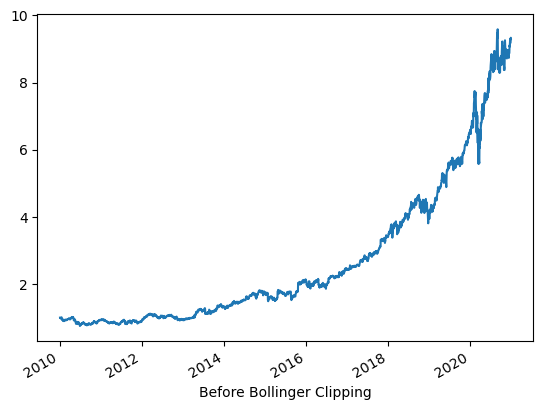

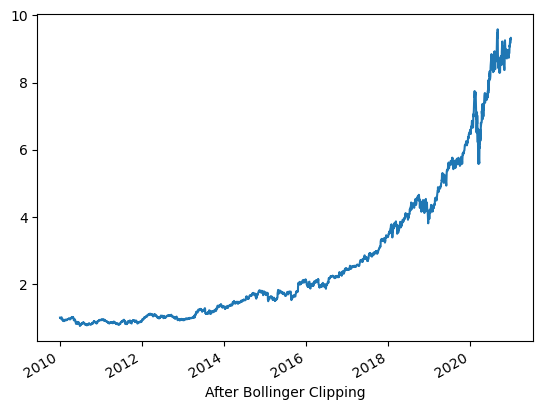

In [11]:
plot_df(df, "Before Bollinger Clipping")
df = clip_to_bollinger_bands(df, input_window_size)
plot_df(df, "After Bollinger Clipping")

After Bollinger Clipping we have first (input_window_size - 1) elements as NaN

In [12]:
df.head(15)

,Adj. Close
2010-01-04,1.000000
2010-01-05,1.000323
2010-01-06,0.994184
2010-01-07,0.983845
2010-01-08,0.990630
2010-01-11,0.978029
2010-01-12,0.971567
2010-01-13,0.980614
2010-01-14,1.000323
2010-01-15,0.997092


In [13]:
df.isna().sum()

Adj. Close    0
dtype: int64

In [14]:
df = df.dropna()
print(df.isna().sum())
print(df.shape)

Adj. Close    0
dtype: int64
(2767, 1)


In [15]:
data = list(df['Adj. Close'])
len(data)

2767

## Train, Validation and Test data

### For DNN

Train+Validation : Test = 80 : 20

In [16]:
train_till = int(0.8*len(data))  # this is train + validation

train_raw_data = data[:train_till]
test_raw_data = data[train_till:]

train_features = [train_raw_data[i:i+input_window_size] for i in range(len(train_raw_data)-input_window_size)]
test_features = [test_raw_data[i:i+input_window_size] for i in range(len(test_raw_data)-input_window_size)]

train_labels = train_raw_data[input_window_size:]
test_labels = test_raw_data[input_window_size:]

print(len(train_features), len(train_labels))
print(len(test_features), len(test_labels))

2203 2203
544 544


In [17]:
train_features = pd.DataFrame.from_records(train_features)
test_features = pd.DataFrame.from_records(test_features)

train_labels = pd.DataFrame(train_labels)
test_labels = pd.DataFrame(test_labels)

print(train_features.shape, train_labels.shape)
print(test_features.shape, test_labels.shape)

(2203, 10) (2203, 1)
(544, 10) (544, 1)


## Build the model

In [18]:
def build_model():
    model = keras.Sequential([
        keras.layers.Dense(10, activation=tf.nn.relu, input_shape=[input_window_size]),
        keras.layers.Dense(5, activation=tf.nn.relu),
        keras.layers.Dense(1)
    ])
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [19]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                110       
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________


## Train the model

### Without Early Stopping

In [20]:
n_epochs = 500
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 50 == 0: print()
        print('.', end='')

history = model.fit(train_features, train_labels, epochs=n_epochs, validation_split=0.2,
                    verbose=0, callbacks=[PrintDot()])


..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................

In [21]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
495,0.000432,0.001883,495
496,0.000416,0.002233,496
497,0.000426,0.002699,497
498,0.000417,0.001889,498
499,0.000413,0.003117,499


In [22]:
hist.head()

,loss,val_loss,epoch
0,0.614890,0.197277,0
1,0.004510,0.041313,1
2,0.003189,0.033440,2
3,0.002993,0.034019,3
4,0.002812,0.027898,4


In [23]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    # plt.ylabel('Loss  x($10^{-6}$)')
    plt.ylabel('Loss')
    # plt.plot(hist['epoch'], hist['loss']*1000000, label='Train Loss')
    # plt.plot(hist['epoch'], hist['val_loss']*1000000, label='Validation Loss')
    plt.plot(hist['epoch'], hist['loss'], label='Train Loss')
    plt.plot(hist['epoch'], hist['val_loss'], label='Validation Loss')
    # plt.ylim([0, 500])
    plt.legend()

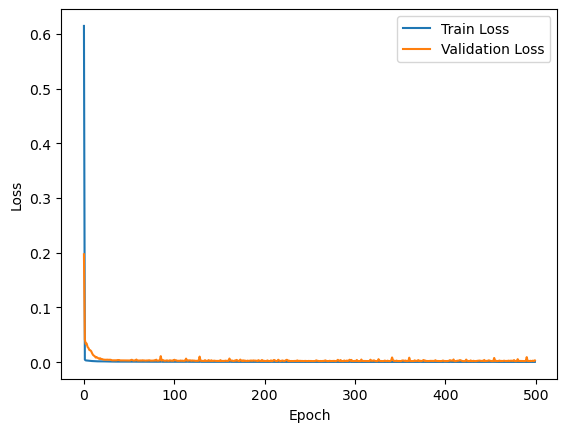

In [24]:
plot_history(history)

### With Early Stopping


..................................................
..................................................
..................................................
..................................................
...............

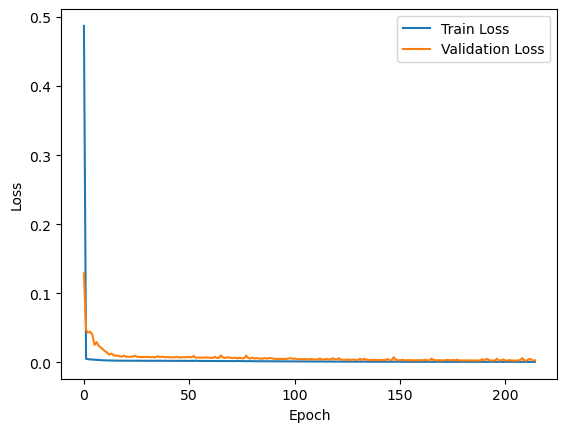

In [25]:
model = build_model()
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(train_features, train_labels, epochs=n_epochs, validation_split=0.2,
                    verbose=0, callbacks=[early_stop, PrintDot()])
plot_history(history)

## Test on test data

In [26]:
loss = model.evaluate(test_features, test_labels)
print("Mean Squared Error on test data = {}".format(loss))

17/17 [==============================] - 0s 976us/step - loss: 0.0260
Mean Squared Error on test data = 0.02596374601125717


## Make Predictions

In [27]:
test_predictions = model.predict(test_features)
test_predictions.shape

17/17 [==============================] - 0s 1ms/step


(544, 1)

In [28]:
test_predictions[:10]

array([[4.229975 ],
       [4.249457 ],
       [4.213568 ],
       [4.221516 ],
       [4.3225293],
       [4.307702 ],
       [4.328265 ],
       [4.4243174],
       [4.4581156],
       [4.401298 ]], dtype=float32)

In [29]:
test_predictions[:10]*denorm_const

array([[ 99.115074],
       [ 99.57156 ],
       [ 98.73063 ],
       [ 98.91686 ],
       [101.28377 ],
       [100.93634 ],
       [101.41817 ],
       [103.66882 ],
       [104.46077 ],
       [103.12944 ]], dtype=float32)

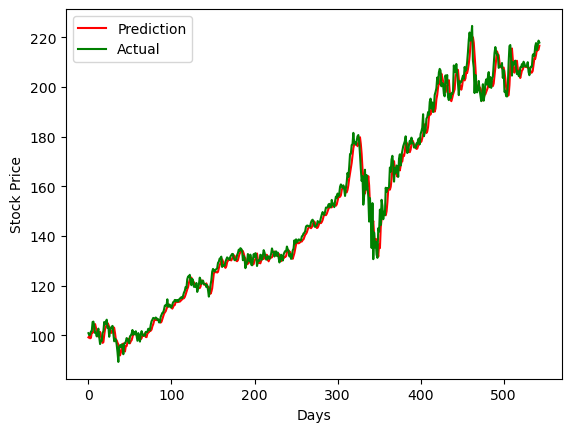

In [30]:
plt.figure()
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.plot(test_predictions*denorm_const, 'r', label='Prediction')
plt.plot(test_labels[0]*denorm_const, 'g', label='Actual')
plt.legend()
plt.show()

In [31]:
mae = np.mean(np.abs(test_labels - test_predictions ))
print(mae)
rmse = np.sqrt(np.mean((test_labels - test_predictions) ** 2))
print(rmse)
#tính độ chính xác của dự báo
mape = np.mean(np.abs((test_labels - test_predictions )/ test_labels)) *100
print(mape)

0.11501978683605682
0.1611326960481754
1.7656785407882236
